In [ ]:
# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 드라이브 내 데이터 폴더 위치
#folder_path ='/content/drive/MyDrive/5-1/ESAA/dacon_card_data' # 지현
#folder_path = '/content/drive/MyDrive/ESAA_OB_HW/ESAA_Project/Credit_card' # 시현
folder_path = '/content/drive/MyDrive/ESAA_OB/project1' #현주

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv(f'{folder_path}/train.csv')
test = pd.read_csv(f'{folder_path}/test.csv')
sample_submission = pd.read_csv(f'{folder_path}/sample_submission.csv')

# 통일 전처리

## df = train + test concat

In [ ]:
print(train.shape)
print(test.shape)

(26457, 20)
(10000, 19)


In [ ]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)
df.shape

(36457, 20)

## FLAG_MOBIL, index, child_num 삭제

In [ ]:
df.drop(['index','FLAG_MOBIL','child_num'], axis=1, inplace=True)

## employed_age -> New column생성 (DAYS_BIRTH - DAYS_EMPLOYED)를 365로 나눔 => 몇살때 취뽀?

In [ ]:
# DAYS_EMPLOYED = 365243 인 사람들 제외한 사람들의 employed_age는 그대로 뺄셈으로 계산

# Filter the DataFrame based on condition
filtered_df = df[df["DAYS_EMPLOYED"] != 365243]

# Calculate 'employed_age' for the filtered rows and assign it to a new column
df.loc[filtered_df.index, 'employed_age'] = (filtered_df['DAYS_BIRTH'] - filtered_df['DAYS_EMPLOYED']).abs() // 365

In [ ]:
df[df["DAYS_EMPLOYED"] == 365243][['DAYS_EMPLOYED','employed_age']].head()

,DAYS_EMPLOYED,employed_age
14,365243,NaN
18,365243,NaN
21,365243,NaN
24,365243,NaN
46,365243,NaN


In [ ]:
med_employed_age = df[df["DAYS_EMPLOYED"] != 365243]['employed_age'].median()
print(med_employed_age)

31.0


In [ ]:
# DAYS_EMPLOYED = 365243 인 사람들은 본인들 제외한 employed_age의 중앙값으로 대체해줌


# Filter the DataFrame based on condition
filtered_df = df[df["DAYS_EMPLOYED"] == 365243]
# 값 대체
df.loc[filtered_df.index, 'employed_age'] = med_employed_age

In [ ]:
df['employed_age'].describe()

count    36457.000000
mean        32.500535
std          8.760307
min         17.000000
25%         26.000000
50%         31.000000
75%         38.000000
max         65.000000
Name: employed_age, dtype: float64

In [ ]:
df[df["DAYS_EMPLOYED"] == 365243][['DAYS_EMPLOYED','employed_age']].head()

,DAYS_EMPLOYED,employed_age
14,365243,31.0
18,365243,31.0
21,365243,31.0
24,365243,31.0
46,365243,31.0


In [ ]:
df[df["DAYS_EMPLOYED"] != 365243][['DAYS_EMPLOYED','employed_age']].head()

,DAYS_EMPLOYED,employed_age
0,-4709,25.0
1,-1540,26.0
2,-4434,40.0
3,-2092,35.0
4,-2105,35.0


## DAYS_BIRTH - abs()

In [ ]:
# 음수를 양수로 전환
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].abs()

## age 칼럼 생성 후 DAYS_BIRTH 삭제

In [ ]:
df['age'] = df['DAYS_BIRTH']//365
df.drop(['DAYS_BIRTH'], axis=1, inplace=True)

## DAYS_EMPLOYED - 365243 중앙값 대체 및 절댓값

In [ ]:
# DAYS_EMPLOYED의 365243들을 중앙값으로
DAYS_EMPLOYED_median = df[df["DAYS_EMPLOYED"]!=365243]['DAYS_EMPLOYED'].median()
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243,DAYS_EMPLOYED_median)
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].abs()
df['DAYS_EMPLOYED']

0         4709
1         1540
2         4434
3         2092
4         2105
         ...  
36452     5434
36453     1315
36454    14018
36455     1085
36456      187
Name: DAYS_EMPLOYED, Length: 36457, dtype: int64

## DAYS_EMPLOYED(median 대체후 abs된 상태), income_total 로그 변환

(array([3.0000e+00, 4.0000e+00, 5.4000e+02, 1.2100e+03, 2.2190e+03,
        4.1990e+03, 1.3574e+04, 8.7910e+03, 4.6440e+03, 1.2730e+03]),
 array([2.89037176, 3.56756531, 4.24475887, 4.92195242, 5.59914598,
        6.27633954, 6.95353309, 7.63072665, 8.3079202 , 8.98511376,
        9.66230731]),
 <BarContainer object of 10 artists>)

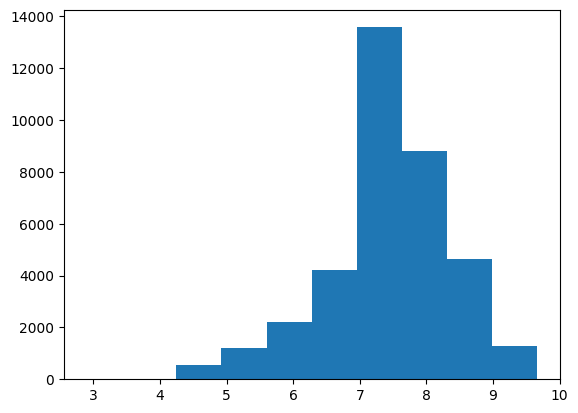

In [ ]:
# Log Normalization
df['log_income_total'] = np.log1p(df['income_total'])
df.drop(['income_total'], axis=1, inplace=True)

df['log_DAYS_EMPLOYED'] = np.log1p(df['DAYS_EMPLOYED'])
df.drop(['DAYS_EMPLOYED'], axis=1, inplace=True)
plt.hist(df['log_DAYS_EMPLOYED'])

## occyp_type - NA대체

In [ ]:
# NA를 income_type이 Pensioner 인 경우 occyp_type을 "retired"로 지정
# 그 외 income_type 은 해당_income_type_unanswered로 occyp_type 지정

for typ in list(df["income_type"].unique()):
  if typ == "Pensioner":
    df[df["income_type"]==typ] = df[df["income_type"]==typ].fillna("retired")
  else:
    df[df["income_type"]==typ] = df[df["income_type"]==typ].fillna(typ+"_unanswered")

print("\n{}".format(df.isna().sum()))


gender               0
car                  0
reality              0
income_type          0
edu_type             0
family_type          0
house_type           0
work_phone           0
phone                0
email                0
occyp_type           0
family_size          0
begin_month          0
credit               0
employed_age         0
age                  0
log_income_total     0
log_DAYS_EMPLOYED    0
dtype: int64


## begin_month : abs()처리

In [ ]:
df['begin_month'] = df['begin_month'].abs()

## gender, car, reality (binary 인코딩) => Label Encoding

In [ ]:
#LabelEncoder 클래스 이용하기
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['gender']=le.fit_transform(df['gender'])
df['car']=le.fit_transform(df['car'])
df['reality']=le.fit_transform(df['reality'])

## income_type, family_type, house type, occyp_type (원-핫 인코딩) => pd.get_dummies()

In [ ]:
df = pd.get_dummies(df,
                    columns = ['income_type','family_type','house_type','occyp_type'],
                    prefix = ['income_type','family_type','house_type', 'occyp_type'])

## edu_type  - rank encoding

In [ ]:
edu_type_mapping = {
    'Lower secondary': 1,
    'Secondary / secondary special': 2,
    'Incomplete higher': 3,
    'Higher education': 4,
    'Academic degree': 5
}

# Create the new encoded column using the map function
df['edu_type_encoded'] = df['edu_type'].map(edu_type_mapping)

In [ ]:
df[['edu_type', 'edu_type_encoded']].head()

,edu_type,edu_type_encoded
0,Higher education,4
1,Secondary / secondary special,2
2,Higher education,4
3,Secondary / secondary special,2
4,Higher education,4


In [ ]:
df.drop(['edu_type'], axis=1, inplace=True)

# 일단 여기까지 df export

In [ ]:
df.to_csv('df3.csv', index=False)

In [ ]:
df.columns

Index(['gender', 'car', 'reality', 'work_phone', 'phone', 'email',
       'family_size', 'begin_month', 'credit', 'employed_age', 'age',
       'log_income_total', 'log_DAYS_EMPLOYED',
       'income_type_Commercial associate', 'income_type_Pensioner',
       'income_type_State servant', 'income_type_Student',
       'income_type_Working', 'family_type_Civil marriage',
       'family_type_Married', 'family_type_Separated',
       'family_type_Single / not married', 'family_type_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Accountants', 'occyp_type_Cleaning staff',
       'occyp_type_Commercial associate_unanswered',
       'occyp_type_Cooking staff', 'occyp_type_Core staff',
       'occyp_type_Drivers', 'occyp_type_HR staff',
       'occyp_type_High skill tech staff', 'occyp_type_IT staff',
       'oc

# Reload df

In [ ]:
df = pd.read_csv(f'{folder_path}/df3.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ESAA_OB/project1/df3.csv'